In [25]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
from tqdm import tqdm
from tensorflow import stack
from keras import initializers
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Input
from keras.layers import Conv1D, LSTM, Dropout, TimeDistributed, RepeatVector
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.ensemble import IsolationForest
from keras import regularizers
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [26]:
df = pd.read_csv("./Data/WISDM.csv", index_col=0)
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.6946377,12.6805440,0.5039529
1,33,Jogging,49106062271000,5.0122880,11.2640280,0.9534243
2,33,Jogging,49106112167000,4.9033250,10.8826580,-0.0817221
3,33,Jogging,49106222305000,-0.6129156,18.4964310,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.1084890,7.2051640
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.0000000,-1.5700000,1.6900000
1098200,19,Sitting,131623371431000,9.0400000,-1.4600000,1.7300000
1098201,19,Sitting,131623411592000,9.0800000,-1.3800000,1.6900000
1098202,19,Sitting,131623491487000,9.0000000,-1.4600000,1.7300000


In [27]:
df.rename(columns={'activity': 'label'}, inplace=True)
df

,user-id,label,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.6946377,12.6805440,0.5039529
1,33,Jogging,49106062271000,5.0122880,11.2640280,0.9534243
2,33,Jogging,49106112167000,4.9033250,10.8826580,-0.0817221
3,33,Jogging,49106222305000,-0.6129156,18.4964310,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.1084890,7.2051640
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.0000000,-1.5700000,1.6900000
1098200,19,Sitting,131623371431000,9.0400000,-1.4600000,1.7300000
1098201,19,Sitting,131623411592000,9.0800000,-1.3800000,1.6900000
1098202,19,Sitting,131623491487000,9.0000000,-1.4600000,1.7300000


In [28]:
df_sitting = df[df['label'] == 'Jogging'].sample(n=45000, random_state=42)
df_jogging = df[df['label'] == 'Sitting'].sample(n=45000, random_state=42)
len(df_sitting), len(df_jogging)

(45000, 45000)

In [29]:
df_train = pd.concat([df_sitting, df_jogging], axis=0)
df_train

,user-id,label,timestamp,X,Y,Z
110810,13,Jogging,0,0.0000000,0.0000000,0.0000000
164275,6,Jogging,2694792247000,-0.4600000,-0.4600000,1.3347940
813141,31,Jogging,23960721626000,19.0800000,18.3500000,2.9100000
1002308,2,Jogging,9022662336000,3.0600000,-0.3000000,1.9200000
815984,31,Jogging,24102851723000,-0.2300000,4.2500000,-4.7100000
...,...,...,...,...,...,...
458469,35,Sitting,185642650000,5.0500000,6.7800000,5.6300000
830097,31,Sitting,25015871376000,0.8900000,-0.2300000,9.7000000
685016,4,Sitting,3624542339000,-7.1600000,-0.8000000,-6.8900000
707332,30,Sitting,1498822307000,3.6000000,6.6300000,-6.9700000


In [30]:
df_train['label'] = df_train['label'].replace({'Sitting': 0, 'Jogging': 1})
df_train

,user-id,label,timestamp,X,Y,Z
110810,13,1,0,0.0000000,0.0000000,0.0000000
164275,6,1,2694792247000,-0.4600000,-0.4600000,1.3347940
813141,31,1,23960721626000,19.0800000,18.3500000,2.9100000
1002308,2,1,9022662336000,3.0600000,-0.3000000,1.9200000
815984,31,1,24102851723000,-0.2300000,4.2500000,-4.7100000
...,...,...,...,...,...,...
458469,35,0,185642650000,5.0500000,6.7800000,5.6300000
830097,31,0,25015871376000,0.8900000,-0.2300000,9.7000000
685016,4,0,3624542339000,-7.1600000,-0.8000000,-6.8900000
707332,30,0,1498822307000,3.6000000,6.6300000,-6.9700000


In [31]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((57600, 6), (14400, 6), (18000, 6))

In [32]:
X_train

,user-id,label,timestamp,X,Y,Z
573825,20,0,58858602306000,-0.9500000,3.8700000,9.3000000
577488,20,0,59041782360000,-0.6500000,4.6000000,9.1100000
221807,27,0,12387722638000,3.1500000,9.4300000,1.2666923
1050721,7,0,209292411592000,-6.1300000,-3.4100000,7.0400000
739183,34,0,2004332255000,-3.6800000,-0.9100000,8.3100000
...,...,...,...,...,...,...
583542,20,0,59344492291000,-4.6700000,3.1100000,8.2400000
1097092,19,0,131567961580000,8.9600000,-0.7600000,2.2600000
458317,35,0,178062297000,5.0900000,6.7400000,5.7100000
538646,29,0,295702342000,7.4600000,2.2600000,6.5100000


In [33]:
X_train = X_train[X_train.label == 0]
X_train = X_train.drop(['label', 'user-id', 'timestamp'], axis=1)

X_val = X_val[X_val.label == 0]
X_val = X_val.drop(['label', 'user-id', 'timestamp'], axis=1)

y_test = X_test['label']
X_test = X_test.drop(['label', 'user-id', 'timestamp'], axis=1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [34]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [35]:
# ====== 2) 오토 인코더 모델 학습 및 예측 ======
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()
X_train_AE.shape

(28840, 3)

In [36]:
noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape)

In [37]:
NUM_COL = 3
#Setting the Hyperparameters

#learning_rate = 0.00001
learning_rate = 0.0001
batch_size = 512
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [38]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(NUM_COL, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return generator

In [39]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [40]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    
    return gan

In [41]:
#Training the GAN

#Calculating the number of batches based on the batch size
batch_count = X_train_AE_noisy.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = X_train_AE_noisy[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))              

100%|██████████| 280/280 [02:12<00:00,  2.12it/s]


Epoch 0 Batch 55/56 [D loss: 0.463914] [G loss:0.947741]


Epoch 1 Batch 55/56 [D loss: 0.617782] [G loss:0.676575]


Epoch 2 Batch 55/56 [D loss: 0.478873] [G loss:0.864240]


 62%|██████▏   | 174/280 [00:08<00:04, 23.88it/s]

Epoch 3 Batch 55/56 [D loss: 0.466591] [G loss:1.307119]


Epoch 4 Batch 55/56 [D loss: 0.406572] [G loss:1.464010]


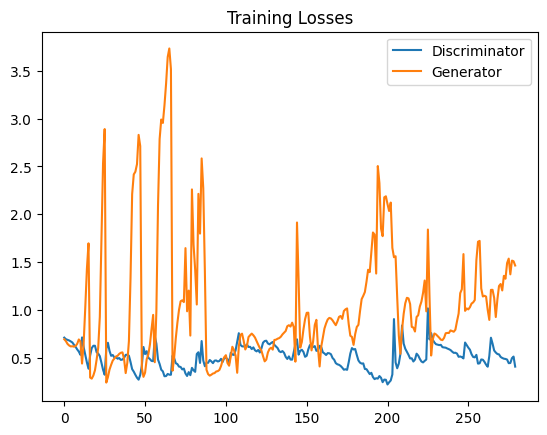

In [42]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [43]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test_AE_noisy.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test_AE_noisy[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [44]:
y2 = y_test.to_numpy()
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())

Mean score for Normal data : 0.7263036987944728
Mean score for Fall data : 0.7245135004394064


In [45]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [46]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.5061111111111111
Precision : 0.8166666666666667
Recall : 0.016326077298978232
F1 : 0.03201219512195122


Confusion Matrix :


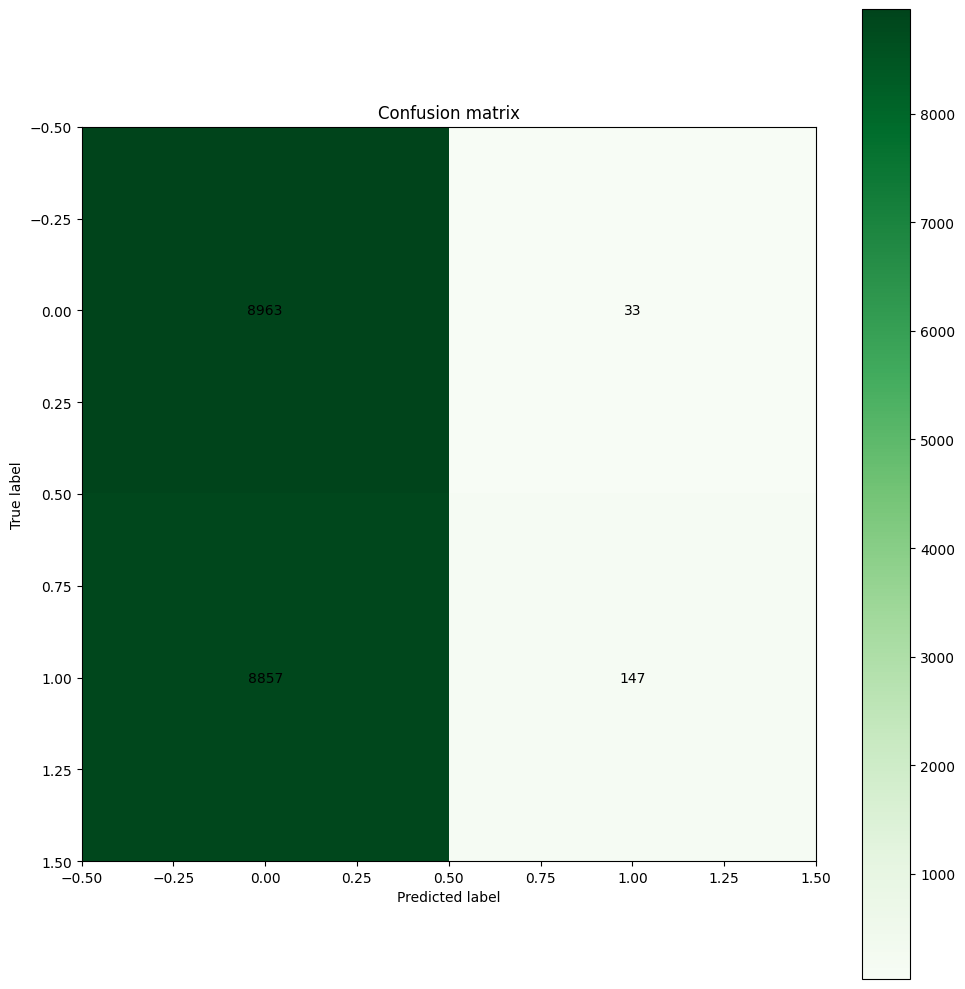

In [47]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

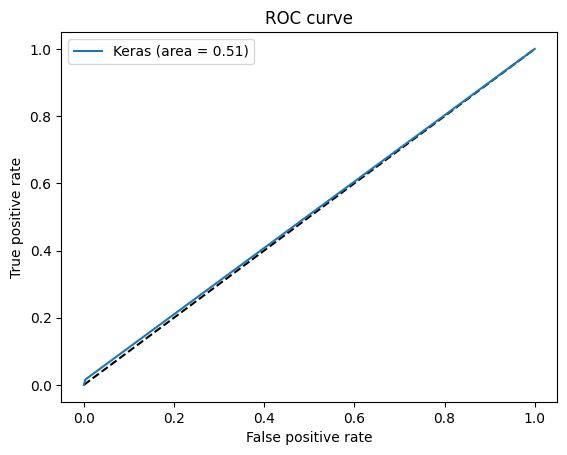

In [48]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()